# ARIMA GARCH Strategy
In this notebook will be explored a simple trading strategy using ARIMA and GARCH models as signals inputs.

### Data
Source: [Binance Exchange](https://www.binance.com/).

### Assets
Not sure yet.

In [12]:
# Import libraries
import datetime as dt
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

# Set plot style
plt.style.use('seaborn')

### [Binance API docs](https://binance-docs.github.io/apidocs)

API json response: <br />

    1499040000000,      // Open time
    "0.01634790",       // Open
    "0.80000000",       // High
    "0.01575800",       // Low
    "0.01577100",       // Close
    "148976.11427815",  // Volume
    1499644799999,      // Close time
    "2434.19055334",    // Quote asset volume
    308,                // Number of trades
    "1756.87402397",    // Taker buy base asset volume - Ask volume?
    "28.46694368",      // Taker buy quote asset volume
    "17928899.62484339" // Ignore.
    
**Quote asset volume it is the volume in the second part of the pair. I.E. BTC/USDT - quote would be BTC volume in USDT.**

In [22]:
# Pair
symbol = 'BTCUSDT'
# Data granularity
interval = '1h'

# URL
root_url = 'https://api.binance.com/api/v3/klines'
url = root_url + '?symbol=' + symbol + '&interval=' + interval
# Download raw data
raw_data = json.loads(requests.get(url).text)

# Open as DF
df = pd.DataFrame(raw_data)
# Change columns' names
df.columns = ['open_time', 
              'o', 'h', 'l', 'c', 'v', 
              'close_time', 'qav', 'num_trades', 
              'taker_base_vol', 'taker_quote_vol', 'ignore'
             ]
# Transform index as datetime object from POSIX timestamp
df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.close_time]
# Drop useless columns
df = df.drop(columns=['open_time', 'close_time', 'ignore'])
# Flip df rows order
df = df.iloc[::-1]

In [23]:
# Map columns' names to data type
cols_type = {'o': 'float32', 'h': 'float32', 'l': 'float32', 
             'c': 'float32', 'v': 'float32', 'qav': 'float32', 
             'num_trades': 'int32', 'taker_base_vol': 'float32', 'taker_quote_vol': 'float32'
            }
# Change columns type to numerical type
df = df.astype(cols_type)
# Check results
df.head()

,o,h,l,c,v,qav,num_trades,taker_base_vol,taker_quote_vol
2020-09-02 15:59:59.999,11353.410156,11389.969727,11318.559570,11367.139648,1835.470825,20842936.0,29986,842.921997,9571893.0
2020-09-02 14:59:59.999,11301.099609,11358.000000,11283.320312,11353.400391,2724.887939,30862990.0,46445,1267.575684,14355760.0
2020-09-02 13:59:59.999,11329.660156,11358.969727,11234.650391,11301.099609,4459.556641,50320144.0,70117,2077.622070,23442602.0
2020-09-02 12:59:59.999,11244.830078,11351.700195,11231.990234,11329.669922,3669.295166,41501840.0,63190,1801.648193,20378330.0
2020-09-02 11:59:59.999,11338.549805,11368.179688,11193.790039,11244.820312,5401.205078,61014428.0,73051,2317.781982,26199022.0


### Calculate log returns
Using log returns instead of prices we already removed possible trends.

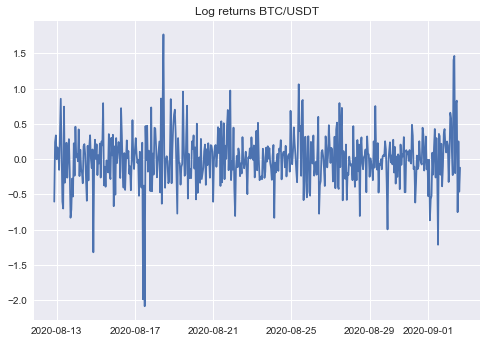

In [48]:
# Compute log_returns
log_ret = np.log(1 + df['c'].pct_change()[1:]) * 100

# Plot results
plt.plot(log_ret.index, log_ret)
plt.title('Log returns BTC/USDT')
plt.show()

## Tests and fit models

### Augmented Dickey-Fuller test
Statiscal test to check if our series is indeed stationary. If not it isn't possible to fit an ARIMA or GARCH model.

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root (stationary), with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

In [59]:
# Import test
from statsmodels.tsa.stattools import adfuller

# Test
stationary_test = adfuller(log_ret)
# Pvalue is stored at index 1
pvalue = stationary_test[1]

print('Pvalue for test: ' + str(pvalue))

Pvalue for test: 0.0


For this pvalue we reject the null hypothesis of unit root, then it means our series is stationary.

### Autocorrelation and partial autocorrelation plots
To identify wich parameters to choose in an ARIMA or GARCH models we must look at the autocorrelation plots.

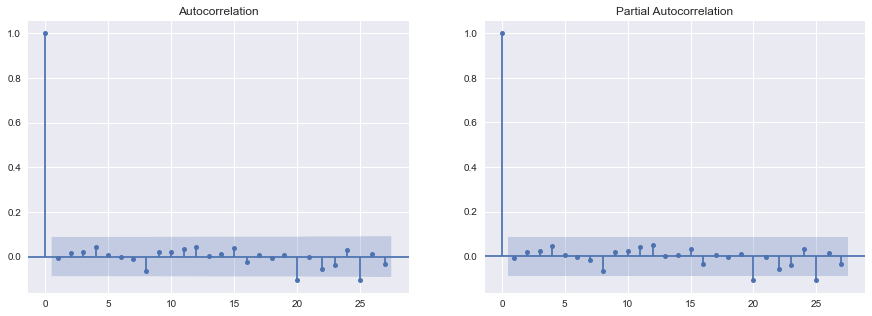

In [68]:
# Import plot functions
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Create figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Plot
plot_acf(log_ret, ax=ax1)
plot_pacf(log_ret, ax=ax2)

plt.show()

They indicate that an ARIMA model is not present in the mean. Let's square the series and check for autocorrelation in volatility.

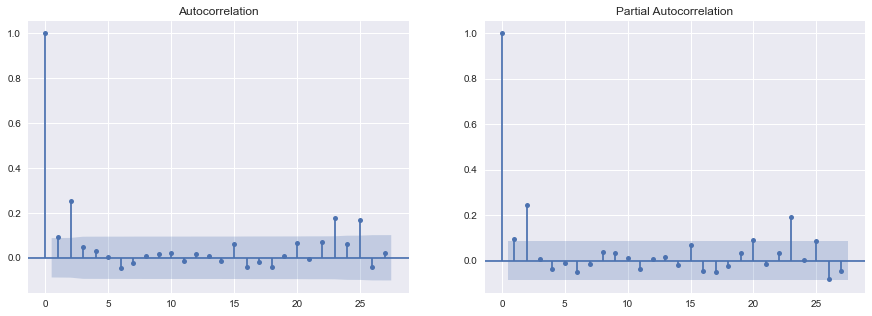

In [69]:
# Square series
ret_sq = log_ret ** 2

# Create figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Plot
plot_acf(ret_sq, ax=ax1)
plot_pacf(ret_sq, ax=ax2)

plt.show()

There is autocorrelation for lag 2.

In [71]:
# Import model
from arch import arch_model

# Iterate through values of p and q
models = {}
for p in range(1, 5):
    for q in range(1, 5):
        label = '({},{})'.format(p, q)
        
        model = arch_model(ret, mean='Zero', vol='GARCH', p=p, q=q).fit(disp='off')
        models[label] = model

## Choose best model
Ljung-box test was made to check if residuals are white noise, the null hypothesis is the presence of white noise. For pvalues above a critical value (5%) we must accept the null hypothesis.

Then the best model according to information criteria was choosen.

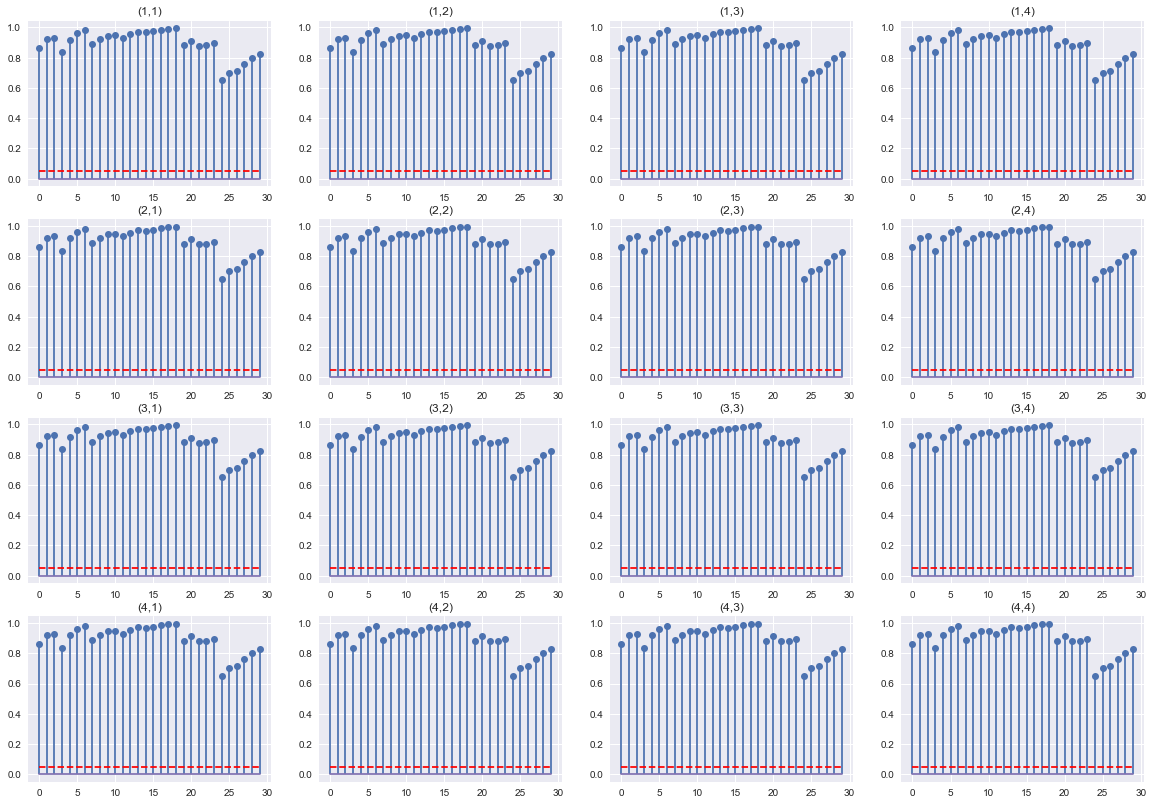

In [110]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Plot size
plt.figure(figsize=(20, 14))

# Choose critical pvalue and number of lags
critical_pvalue = 0.05
lags = 30

# Test and show results in plot
index = 1
for key, model in models.items():
    # Test
    test = acorr_ljungbox(model.resid, lags=lags, return_df=True)
    
    # Show results
    plt.subplot(4, 4, index)
    plt.stem(test['lb_pvalue'])
    plt.hlines(critical_pvalue, 0, lags-1, ls='--', color='red')
    # Set title
    plt.title(key)
    
    # Change plot position in subplots
    index += 1

plt.show()

All models have white noise as residuals.

In [119]:
# Select all AIC from models
aic = {}
for key, model in models.items():
    aic[key] = (model.aic)

# Transform into pandas object
aic = pd.Series(aic)
# The lowest value for AIC is the best one
aic.sort_values(ascending=True).head()

(1,1)    432.836346
(2,1)    433.637424
(1,2)    434.836346
(3,1)    435.575927
(2,2)    435.624569
dtype: float64

# Tecnicas de previsão forecast 1
# Construir bandas com pt e desvio previsto para t+1
# Back test